(sp)=

# SciPy

## Overview

[SciPy](http://www.scipy.org) builds on top of NumPy to provide common
tools for scientific programming such as

-   [linear algebra](http://docs.scipy.org/doc/scipy/reference/linalg.html)
-   [numerical
    integration](http://docs.scipy.org/doc/scipy/reference/integrate.html)
-   [interpolation](http://docs.scipy.org/doc/scipy/reference/interpolate.html)
-   [optimization](http://docs.scipy.org/doc/scipy/reference/optimize.html)
-   [distributions and random number generation](http://docs.scipy.org/doc/scipy/reference/stats.html)
-   [signal processing](http://docs.scipy.org/doc/scipy/reference/signal.html)
-   etc., etc

Like NumPy, SciPy is stable, mature and widely used.

Many SciPy routines are thin wrappers around industry-standard Fortran
libraries such as [LAPACK](https://en.wikipedia.org/wiki/LAPACK),
[BLAS](https://en.wikipedia.org/wiki/Basic_Linear_Algebra_Subprograms),
etc.

It\'s not really necessary to \"learn\" SciPy as a whole.

A more common approach is to get some idea of what\'s in the library and
then look up
[documentation](http://docs.scipy.org/doc/scipy/reference/index.html) as
required.

In this lecture, we aim only to highlight some useful parts of the
package.

## SciPy versus NumPy

SciPy is a package that contains various tools that are built on top of
NumPy, using its array data type and related functionality.

In fact, when we import SciPy we also get NumPy, as can be seen from
this excerpt the SciPy initialization file:

In [1]:
# Import numpy symbols to scipy namespace
from numpy import *
from numpy.random import rand, randn
from numpy.fft import fft, ifft
from numpy.lib.scimath import *

However, it\'s more common and better practice to use NumPy
functionality explicitly

In [2]:
import numpy as np

a = np.identity(3)

What is useful in SciPy is the functionality in its sub-packages

-   `scipy.optimize`, `scipy.integrate`, `scipy.stats`, etc.

Let\'s explore some of the major sub-packages.

## Statistics

The `scipy.stats` subpackage supplies

-   numerous random variable objects (densities, cumulative
    distributions, random sampling, etc.)
-   some estimation procedures
-   some statistical tests

### Random Variables and Distributions

Recall that `numpy.random` provides functions for generating random
variables

In [3]:
np.random.beta(5, 5, size=3)

array([0.43801   , 0.32453087, 0.18273029])

This generates a draw from the distribution with the density function
below when `a, b = 5, 5`

$$
f(x; a, b) = \frac{x^{(a - 1)} (1 - x)^{(b - 1)}}
    {\int_0^1 u^{(a - 1)} (1 - u)^{(b - 1)} du}
    \qquad (0 \leq x \leq 1)
$$

Sometimes we need access to the density itself, or the cdf, the
quantiles, etc.

For this, we can use `scipy.stats`, which provides all of this
functionality as well as random number generation in a single consistent
interface.

Here\'s an example of usage

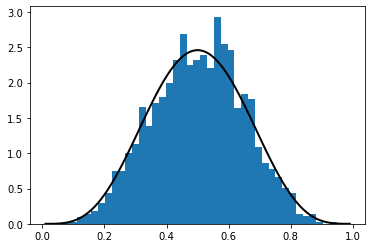

In [4]:
from scipy.stats import beta
import matplotlib.pyplot as plt
%matplotlib inline

q = beta(5, 5)      # Beta(a, b), with a = b = 5
obs = q.rvs(2000)   # 2000 observations
grid = np.linspace(0.01, 0.99, 100)

fig, ax = plt.subplots()
ax.hist(obs, bins=40, density=True)
ax.plot(grid, q.pdf(grid), 'k-', linewidth=2)
plt.show()

The object `q` that represents the distribution has additional useful
methods, including

In [5]:
q.cdf(0.4)      # Cumulative distribution function

0.26656768000000003

In [6]:
q.ppf(0.8)      # Quantile (inverse cdf) function

0.6339134834642708

In [7]:
q.mean()

0.5

The general syntax for creating these objects that represent
distributions (of type `rv_frozen`) is

> `name = scipy.stats.distribution_name(shape_parameters, loc=c, scale=d)`

Here `distribution_name` is one of the distribution names in
[scipy.stats](http://docs.scipy.org/doc/scipy/reference/stats.html).

The `loc` and `scale` parameters transform the original random variable
$X$ into $Y = c + d X$.

### Alternative Syntax

There is an alternative way of calling the methods described above.

For example, the code that generates the figure above can be replaced by

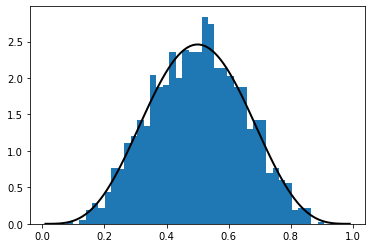

In [8]:
obs = beta.rvs(5, 5, size=2000)
grid = np.linspace(0.01, 0.99, 100)

fig, ax = plt.subplots()
ax.hist(obs, bins=40, density=True)
ax.plot(grid, beta.pdf(grid, 5, 5), 'k-', linewidth=2)
plt.show()

### Other Goodies in scipy.stats

There are a variety of statistical functions in `scipy.stats`.

For example, `scipy.stats.linregress` implements simple linear
regression

In [9]:
from scipy.stats import linregress

x = np.random.randn(200)
y = 2 * x + 0.1 * np.random.randn(200)
gradient, intercept, r_value, p_value, std_err = linregress(x, y)
gradient, intercept

(2.010089867052359, 0.005221764813504427)

To see the full list, consult the
[documentation](https://docs.scipy.org/doc/scipy/reference/stats.html#statistical-functions-scipy-stats).

## Roots and Fixed Points

A **root** or **zero** of a real function $f$ on $[a,b]$ is an
$x \in [a, b]$ such that $f(x)=0$.

For example, if we plot the function

```{math}
---
label: root_f
---
f(x) = \sin(4 (x - 1/4)) + x + x^{20} - 1
```

with $x \in [0,1]$ we get

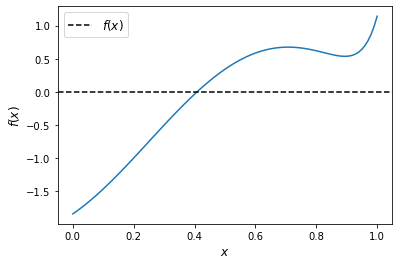

In [10]:
f = lambda x: np.sin(4 * (x - 1/4)) + x + x**20 - 1
x = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
ax.plot(x, f(x))
ax.axhline(ls='--', c='k', label='$f(x)$')
ax.set_xlabel('$x$', fontsize=12)
ax.set_ylabel('$f(x)$', fontsize=12)
ax.legend(fontsize=12)
plt.show()

The unique root is approximately 0.408.

Let\'s consider some numerical techniques for finding roots.

### Bisection

One of the most common algorithms for numerical root-finding is
*bisection*.

To understand the idea, recall the well-known game where

-   Player A thinks of a secret number between 1 and 100
-   Player B asks if it\'s less than 50

    > -   If yes, B asks if it\'s less than 25
    > -   If no, B asks if it\'s less than 75

And so on.

This is bisection.

Here\'s a simplistic implementation of the algorithm in Python.

It works for all sufficiently well behaved increasing continuous
functions with $f(a) < 0 < f(b)$

(bisect_func)=

In [11]:
def bisect(f, a, b, tol=10e-5):
    """
    Implements the bisection root finding algorithm, assuming that f is a
    real-valued function on [a, b] satisfying f(a) < 0 < f(b).
    """
    lower, upper = a, b

    while upper - lower > tol:
        middle = 0.5 * (upper + lower)
        if f(middle) > 0:   # root is between lower and middle 
            lower, upper = lower, middle
        else:               # root is between middle and upper 
            lower, upper = middle, upper

    return 0.5 * (upper + lower)

Let\'s test it using the function $f$ defined in
{math:numref}`root_f`

In [12]:
bisect(f, 0, 1)

0.408294677734375

Not surprisingly, SciPy provides its own bisection function.

Let\'s test it using the same function $f$ defined in
{math:numref}`root_f`

In [13]:
from scipy.optimize import bisect

bisect(f, 0, 1)

0.4082935042806639

### The Newton-Raphson Method

Another very common root-finding algorithm is the [Newton-Raphson
method](https://en.wikipedia.org/wiki/Newton%27s_method).

In SciPy this algorithm is implemented by `scipy.optimize.newton`.

Unlike bisection, the Newton-Raphson method uses local slope information
in an attempt to increase the speed of convergence.

Let\'s investigate this using the same function $f$ defined above.

With a suitable initial condition for the search we get convergence:

In [14]:
from scipy.optimize import newton

newton(f, 0.2)   # Start the search at initial condition x = 0.2

0.40829350427935673

But other initial conditions lead to failure of convergence:

In [15]:
newton(f, 0.7)   # Start the search at x = 0.7 instead

0.7001700000000279

### Hybrid Methods

A general principle of numerical methods is as follows:

-   If you have specific knowledge about a given problem, you might be
    able to exploit it to generate efficiency.
-   If not, then the choice of algorithm involves a trade-off between
    speed and robustness.

In practice, most default algorithms for root-finding, optimization and
fixed points use *hybrid* methods.

These methods typically combine a fast method with a robust method in
the following manner:

1.  Attempt to use a fast method
2.  Check diagnostics
3.  If diagnostics are bad, then switch to a more robust algorithm

In `scipy.optimize`, the function `brentq` is such a hybrid method and a
good default

In [16]:
from scipy.optimize import brentq

brentq(f, 0, 1)

0.40829350427936706

Here the correct solution is found and the speed is better than
bisection:

In [17]:
%timeit brentq(f, 0, 1)

24.6 µs ± 1.24 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [18]:
%timeit bisect(f, 0, 1)

92.5 µs ± 2.13 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Multivariate Root-Finding

Use `scipy.optimize.fsolve`, a wrapper for a hybrid method in MINPACK.

See the
[documentation](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html)
for details.

### Fixed Points

A **fixed point** of a real function $f$ on $[a,b]$ is an $x \in [a, b]$
such that $f(x)=x$.

SciPy has a function for finding (scalar) fixed points too

In [19]:
from scipy.optimize import fixed_point

fixed_point(lambda x: x**2, 10.0)  # 10.0 is an initial guess

array(1.)

If you don\'t get good results, you can always switch back to the
`brentq` root finder, since the fixed point of a function $f$ is the
root of $g(x) := x - f(x)$.

## Optimization

Most numerical packages provide only functions for *minimization*.

Maximization can be performed by recalling that the maximizer of a
function $f$ on domain $D$ is the minimizer of $-f$ on $D$.

Minimization is closely related to root-finding: For smooth functions,
interior optima correspond to roots of the first derivative.

The speed/robustness trade-off described above is present with numerical
optimization too.

Unless you have some prior information you can exploit, it\'s usually
best to use hybrid methods.

For constrained, univariate (i.e., scalar) minimization, a good hybrid
option is `fminbound`

In [20]:
from scipy.optimize import fminbound

fminbound(lambda x: x**2, -1, 2)  # Search in [-1, 2]

0.0

### Multivariate Optimization

Multivariate local optimizers include `minimize`, `fmin`, `fmin_powell`,
`fmin_cg`, `fmin_bfgs`, and `fmin_ncg`.

Constrained multivariate local optimizers include `fmin_l_bfgs_b`,
`fmin_tnc`, `fmin_cobyla`.

See the
[documentation](http://docs.scipy.org/doc/scipy/reference/optimize.html)
for details.

## Integration

Most numerical integration methods work by computing the integral of an
approximating polynomial.

The resulting error depends on how well the polynomial fits the
integrand, which in turn depends on how \"regular\" the integrand is.

In SciPy, the relevant module for numerical integration is
`scipy.integrate`.

A good default for univariate integration is `quad`

In [21]:
from scipy.integrate import quad

integral, error = quad(lambda x: x**2, 0, 1)
integral

0.33333333333333337

In fact, `quad` is an interface to a very standard numerical integration
routine in the Fortran library QUADPACK.

It uses [Clenshaw-Curtis
quadrature](https://en.wikipedia.org/wiki/Clenshaw-Curtis_quadrature),
based on expansion in terms of Chebychev polynomials.

There are other options for univariate integration---a useful one is
`fixed_quad`, which is fast and hence works well inside `for` loops.

There are also functions for multivariate integration.

See the
[documentation](http://docs.scipy.org/doc/scipy/reference/integrate.html)
for more details.

## Linear Algebra

We saw that NumPy provides a module for linear algebra called `linalg`.

SciPy also provides a module for linear algebra with the same name.

The latter is not an exact superset of the former, but overall it has
more functionality.

We leave you to investigate the [set of available
routines](http://docs.scipy.org/doc/scipy/reference/linalg.html).

## Exercises

(sp_ex1)=

### Exercise 1

Previously we discussed the concept of
{ref}`recursive function calls <recursive_functions>`.

Try to write a recursive implementation of homemade bisection function
{ref}`described above <bisect_func>`.

Test it on the function {math:numref}`root_f`.

## Solutions

### Exercise 1

Here\'s a reasonable solution:

In [22]:
def bisect(f, a, b, tol=10e-5):
    """
    Implements the bisection root-finding algorithm, assuming that f is a
    real-valued function on [a, b] satisfying f(a) < 0 < f(b).
    """
    lower, upper = a, b
    if upper - lower < tol:
        return 0.5 * (upper + lower)
    else:
        middle = 0.5 * (upper + lower)
        print(f'Current mid point = {middle}')
        if f(middle) > 0:   # Implies root is between lower and middle
            return bisect(f, lower, middle)
        else:               # Implies root is between middle and upper
            return bisect(f, middle, upper)

We can test it as follows

In [23]:
f = lambda x: np.sin(4 * (x - 0.25)) + x + x**20 - 1
bisect(f, 0, 1)

Current mid point = 0.5
Current mid point = 0.25
Current mid point = 0.375
Current mid point = 0.4375
Current mid point = 0.40625
Current mid point = 0.421875
Current mid point = 0.4140625
Current mid point = 0.41015625
Current mid point = 0.408203125
Current mid point = 0.4091796875
Current mid point = 0.40869140625
Current mid point = 0.408447265625
Current mid point = 0.4083251953125
Current mid point = 0.40826416015625


0.408294677734375